# **Training, testing and evaluation of linear and nonlinear models for WM**

@author: Ruijia & Zaylea

### **Linear models**

In [ ]:
import pandas as pd
import numpy as np
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr  
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Load dataset
data = pd.read_csv('WM_DTI.csv')

# Select ROI feature columns and relevant metadata
roi_columns = [col for col in data.columns if col.startswith('ROI')]
data = data[['CCID'] + roi_columns + ['Sex', 'Age']]

# Encode categorical feature (Sex) as numeric
le = LabelEncoder()
data['Sex'] = le.fit_transform(data['Sex'])

# Define predictors (X) and target variable (y)
X = data[roi_columns + ['Sex']].values
y = data['Age'].values
ccid = data['CCID'].values

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Fix 20% of the data as a test set before training
X_train, X_test, y_train, y_test, ccid_train, ccid_test = train_test_split(
    X, y, ccid, test_size=0.2, random_state=RANDOM_SEED, shuffle=True
)

# Define hyperparameter grids
param_grids = {
    "RidgeRegression": {'alpha': [0.01, 0.1, 1, 10, 100]},
    "LassoRegression": {'alpha': [0.01, 0.1, 1, 10, 100]},
    "ElasticNet": {'alpha': [0.01, 0.1, 1, 10, 100], 'l1_ratio': [0.1, 0.5, 0.9]}
}

# Define linear models
linear_models = {
    "RidgeRegression": Ridge(random_state=RANDOM_SEED, max_iter=100000),
    "LassoRegression": Lasso(random_state=RANDOM_SEED, max_iter=100000),
    "ElasticNet": ElasticNet(random_state=RANDOM_SEED, max_iter=100000)
}

# Train and evaluate models
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
results = {}
best_params = {}

for model_name, model in linear_models.items():
    print(f"\n===== Training {model_name} =====")
    best_params[model_name] = []
    best_scores = []

    # Nested CV to find best hyperparameters
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        grid_search = GridSearchCV(model, param_grids[model_name], cv=5)
        grid_search.fit(X_train_fold, y_train_fold)

        print(f"{model_name} - Fold {fold_idx+1} Best Parameters: {grid_search.best_params_}, Best CV Score: {grid_search.best_score_:.4f}")

        best_params[model_name].append(grid_search.best_params_)
        best_scores.append(grid_search.best_score_)

    # Train final model on full training set
    best_param = max(zip(best_params[model_name], best_scores), key=lambda x: x[1])[0]
    final_model = model.set_params(**best_param)
    final_model.fit(X_train, y_train)

    # Evaluate on fixed test set
    y_pred = final_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mean_age_gap = np.mean(np.abs(y_test - y_pred))

    # Pearson PCC & Spearman SPCC
    pcc, _ = pearsonr(y_test, y_pred)
    spcc, _ = spearmanr(y_test, y_pred)

    results[model_name] = {
        'MSE': mse,
        'MAE': mae,
        'R²': r2,
        'Mean_Age_Gap': mean_age_gap,
        'PCC': pcc,
        'SPCC': spcc
    }

# Print final results
print("\n===== Final Model Performance on Independent Test Set =====")
for model_name, metrics in results.items():
    print(
        f"{model_name} - "
        f"MSE: {metrics['MSE']:.4f}, "
        f"MAE: {metrics['MAE']:.4f}, "
        f"R²: {metrics['R²']:.4f}, "
        f"Mean Age Gap: {metrics['Mean_Age_Gap']:.4f}, "
        f"PCC: {metrics['PCC']:.4f}, "
        f"SPCC: {metrics['SPCC']:.4f}"
    )


===== Training RidgeRegression =====
RidgeRegression - Fold 1 Best Parameters: {'alpha': 100}, Best CV Score: 0.8181
RidgeRegression - Fold 2 Best Parameters: {'alpha': 100}, Best CV Score: 0.8000
RidgeRegression - Fold 3 Best Parameters: {'alpha': 100}, Best CV Score: 0.8177
RidgeRegression - Fold 4 Best Parameters: {'alpha': 100}, Best CV Score: 0.8317
RidgeRegression - Fold 5 Best Parameters: {'alpha': 100}, Best CV Score: 0.8353

===== Training LassoRegression =====
LassoRegression - Fold 1 Best Parameters: {'alpha': 0.1}, Best CV Score: 0.8086
LassoRegression - Fold 2 Best Parameters: {'alpha': 0.1}, Best CV Score: 0.7894
LassoRegression - Fold 3 Best Parameters: {'alpha': 0.1}, Best CV Score: 0.8227
LassoRegression - Fold 4 Best Parameters: {'alpha': 0.1}, Best CV Score: 0.8214
LassoRegression - Fold 5 Best Parameters: {'alpha': 0.1}, Best CV Score: 0.8303

===== Training ElasticNet =====
ElasticNet - Fold 1 Best Parameters: {'alpha': 0.1, 'l1_ratio': 0.5}, Best CV Score: 0.8143

**Top 10 Features for WM Age Prediction (Lasso)**


C:\Users\August\AppData\Local\Temp\ipykernel_43040\2150714005.py:63: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


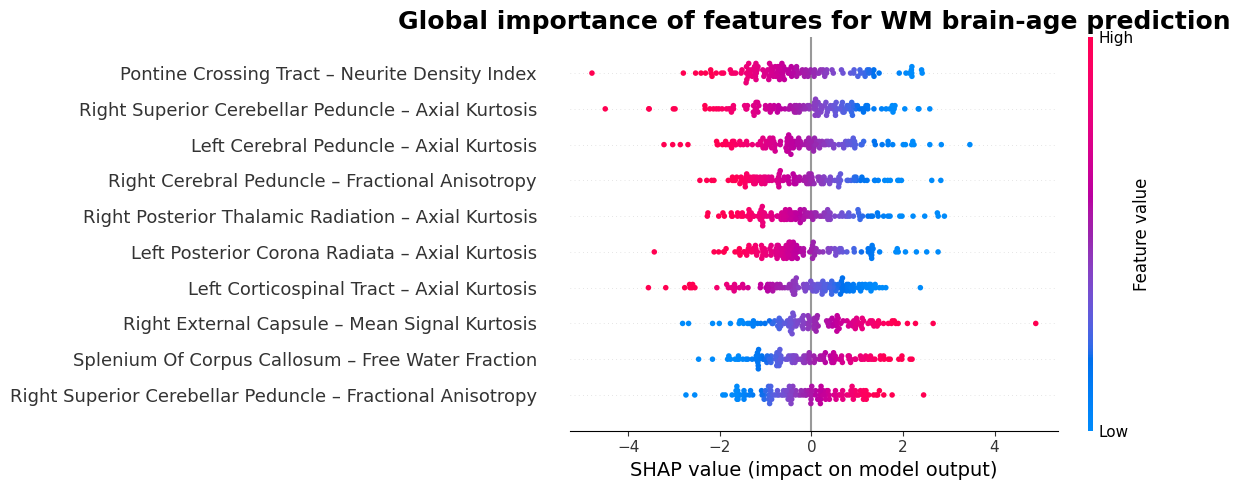

In [ ]:
def pretty_name(feature: str) -> str:
    # Sex special label
    if feature == "Sex":
        return "Sex (label encoded)"

    m = roi_pat.match(feature)
    if not m:
        return feature

    idx = int(m.group(1))
    metric = m.group(2).upper()

    # Lookup ROI anatomical name
    region = ROI_INDEX_TO_NAME.get(idx, f"ROI {idx}")

    # Convert metric abbreviation
    metric_full = METRIC_MAP.get(metric, metric)

    return f"{region} – {metric_full}"


# Ridge model for SHAP
ridge_final = Ridge(alpha=100, random_state=RANDOM_SEED, max_iter=100000)
ridge_final.fit(X_train[:, :-1], y_train)

# Predict on the test set
y_pred = ridge_final.predict(X_test[:, :-1])

# Compute SHAP values
feature_names_all = roi_columns  # ROI feature names only

explainer = shap.LinearExplainer(
    ridge_final,
    X_train[:, :-1],
    feature_names=feature_names_all
)

sv = explainer(X_test[:, :-1])

# Calculate mean absolute SHAP values
sv_values = sv.values if hasattr(sv, "values") else sv
imp = np.abs(sv_values).mean(axis=0)

feature_importance = pd.DataFrame({
    "Feature": feature_names_all,
    "Importance": imp
}).sort_values("Importance", ascending=False)

# Select top 10 features
topK = 10
topk_df = feature_importance.head(topK).copy()

# Corresponding indices
topk_idx = [feature_names_all.index(f) for f in topk_df["Feature"]]
shap_topk = sv_values[:, topk_idx]
X_topk = X_test[:, topk_idx]

# Pretty feature names
names_topk_pretty = [pretty_name(f) for f in topk_df["Feature"]]

# Plot SHAP summary plot for top 10 features
plt.figure(figsize=(30, 20))
shap.summary_plot(
    shap_topk,
    X_topk,
    feature_names=names_topk_pretty,
    plot_type="dot",
    show=False,
    plot_size=(12, 5)
)

plt.title("Global importance of features for WM brain-age prediction",
          fontsize=18, weight="bold")

plt.xlabel("SHAP value (impact on model output)", fontsize=14)
plt.tight_layout()
plt.savefig("shap_summary_top10_ridge.png", dpi=300, bbox_inches="tight")
plt.show()

# Ridge regression coefficients (aligned with ROI features)
coef_all = ridge_final.coef_

# Get coefficients for only the Top 10 features
top10_coefficients = [coef_all[feature_names_all.index(f)] for f in topk_df["Feature"]]

# Build dataframe for the top 10
export_top10_df = pd.DataFrame({
    "Feature": [pretty_name(f) for f in topk_df["Feature"]],
    "Mean_ABS_SHAP_Value": topk_df["Importance"].values,
    "Coefficient": top10_coefficients
})

# Save Top 10 to CSV
export_top10_df.to_csv("WM_Ridge_SHAP_and_Coefficients_TOP10.csv", index=False)

**ROI Dictionary**

In [5]:
import re

# ROI index → anatomical region name
ROI_INDEX_TO_NAME = {
    1: "Unclassified",
    2: "Middle Cerebellar Peduncle",
    3: "Pontine Crossing Tract",
    4: "Genu Of Corpus Callosum",
    5: "Body Of Corpus Callosum",
    6: "Splenium Of Corpus Callosum",
    7: "Fornix",
    8: "Right Corticospinal Tract",
    9: "Left Corticospinal Tract",
    10: "Right Medial Lemniscus",
    11: "Left Medial Lemniscus",
    12: "Right Inferior Cerebellar Peduncle",
    13: "Left Inferior Cerebellar Peduncle",
    14: "Right Superior Cerebellar Peduncle",
    15: "Left Superior Cerebellar Peduncle",
    16: "Right Cerebral Peduncle",
    17: "Left Cerebral Peduncle",
    18: "Right Anterior Limb Of Internal Capsule",
    19: "Left Anterior Limb Of Internal Capsule",
    20: "Right Posterior Limb Of Internal Capsule",
    21: "Left Posterior Limb Of Internal Capsule",
    22: "Right Retrolenticular Part Of Internal Capsule",
    23: "Left Retrolenticular Part Of Internal Capsule",
    24: "Right Anterior Corona Radiata",
    25: "Left Anterior Corona Radiata",
    26: "Right Superior Corona Radiata",
    27: "Left Superior Corona Radiata",
    28: "Right Posterior Corona Radiata",
    29: "Left Posterior Corona Radiata",
    30: "Right Posterior Thalamic Radiation",
    31: "Left Posterior Thalamic Radiation",
    32: "Sagittal Stratum",
    33: "Sagittal Stratum",
    34: "Right External Capsule",
    35: "Left External Capsule",
    36: "Right Cingulum (cingulate gyrus)",
    37: "Left Cingulum (cingulate gyrus)",
    38: "Right Cingulum (hippocampus)",
    39: "Left Cingulum (hippocampus)",
    40: "Fornix (column and body)",
    41: "Fornix (cres)",
    42: "Right Superior Longitudinal Fasciculus",
    43: "Left Superior Longitudinal Fasciculus",
    44: "Right Superior Fronto-Occipital Fasciculus",
    45: "Left Superior Fronto-Occipital Fasciculus",
    46: "Right Uncinate Fasciculus",
    47: "Left Uncinate Fasciculus",
    48: "Right Tapetum",
    49: "Left Tapetum",
}

# Metric abbreviation → full name
METRIC_MAP = {
    "FA":  "Fractional Anisotropy",
    "MD":  "Mean Signal Diffusivity",
    "AK":  "Axial Kurtosis",
    "MK":  "Mean Signal Kurtosis",
    "NDI": "Neurite Density Index",
    "FISO": "Free Water Fraction",
    "OD": "Orientation Dispersion Index",
    "ND": "Neurite Density Index",
    "RK": "Radial Kurtosis"
}

roi_pat = re.compile(r"^ROI_(\d+)_([A-Za-z0-9]+)$")

def pretty_name(feature: str) -> str:
    if feature == "Sex":
        return "Sex (label encoded)"
    m = roi_pat.match(feature)
    if not m:
        return feature
    idx = int(m.group(1))
    metric = m.group(2).upper()
    region = ROI_INDEX_TO_NAME.get(idx, f"ROI {idx}")
    metric_full = METRIC_MAP.get(metric, metric)
    return f"{region} – {metric_full}"

**Different Seeds**

In [6]:
# Perform cross-validation and save Ridge, Lasso, and ElasticNet results
def perform_model_cv_and_save(X, y, seeds=[42, 7, 123, 99, 56, 78]):
    models = {
        "RidgeRegression": Ridge(alpha=100, max_iter=100000),
        "LassoRegression": Lasso(alpha=0.1, max_iter=100000),
        "ElasticNet": ElasticNet(alpha=1, l1_ratio=0.9, max_iter=100000)
    }

    metrics_results = {model_name: {seed: None for seed in seeds} for model_name in models.keys()}

    # Perform cross-validation
    for model_name, model in models.items():
        for seed in seeds:
            np.random.seed(seed)
            kf = KFold(n_splits=10, shuffle=True, random_state=seed)

            metrics = {'MSE': [], 'MAE': [], 'R²': [], 'Mean_Age_Gap': []}

            for train_index, test_index in kf.split(X):
                X_train_cv, X_test_cv = X[train_index], X[test_index]
                y_train_cv, y_test_cv = y[train_index], y[test_index]

                model.fit(X_train_cv, y_train_cv)
                y_pred_cv = model.predict(X_test_cv)

                metrics['MSE'].append(mean_squared_error(y_test_cv, y_pred_cv))
                metrics['MAE'].append(mean_absolute_error(y_test_cv, y_pred_cv))
                metrics['R²'].append(r2_score(y_test_cv, y_pred_cv))
                metrics['Mean_Age_Gap'].append(np.mean(np.abs(y_test_cv - y_pred_cv)))

            metrics_results[model_name][seed] = {metric: np.mean(values) for metric, values in metrics.items()}

    # Visualize different evaluation metrics and save as PNG
    metrics_list = ['MSE', 'MAE', 'R²', 'Mean_Age_Gap']
    colors = sns.color_palette("husl", len(models))
    saved_files = []

    for metric_idx, metric_name in enumerate(metrics_list):
        plt.figure(figsize=(10, 6))

        for model_idx, (model_name, model) in enumerate(models.items()):
            metric_values = [metrics_results[model_name][seed][metric_name] for seed in seeds]
            plt.scatter(seeds, metric_values, label=f"{model_name} - {metric_name}", color=colors[model_idx])
            plt.plot(seeds, metric_values, linestyle='-', color=colors[model_idx])

        plt.ylim(min(min(metrics_results[m][s][metric_name] for s in seeds) for m in models) * 0.9,
                 max(max(metrics_results[m][s][metric_name] for s in seeds) for m in models) * 1.1)

        plt.title(f'{metric_name} Across Different Seeds')
        plt.xlabel('Seed')
        plt.ylabel(metric_name)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        # Save the plot
        filename = f"{metric_name}_comparison_across_seeds.png"
        plt.savefig(filename)
        saved_files.append(filename)
        plt.close()

    return saved_files

# Run the model evaluation
saved_images = perform_model_cv_and_save(X_train, y_train)
print("done", saved_images)

done ['MSE_comparison_across_seeds.png', 'MAE_comparison_across_seeds.png', 'R²_comparison_across_seeds.png', 'Mean_Age_Gap_comparison_across_seeds.png']


### **Nonlinear models**


In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr, spearmanr

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Load dataset
data = pd.read_csv('WM_DTI.csv')

# Select ROI features 
roi_columns = [col for col in data.columns if col.startswith('ROI')]
data = data[['CCID'] + roi_columns + ['Sex', 'Age']]

# Encode categorical feature (Sex) 
le = LabelEncoder()
data['Sex'] = le.fit_transform(data['Sex'])

# Define predictors and target 
X = data[roi_columns + ['Sex']].values
y = data['Age'].values
ccid = data['CCID'].values

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Fix independent test set (20%) 
X_trainval, X_test, y_trainval, y_test, ccid_trainval, ccid_test = train_test_split(
    X, y, ccid, test_size=0.2, random_state=RANDOM_SEED, shuffle=True
)

# Hyperparameter grids
param_grids = {
    "RandomForest": {
        'n_estimators': [50, 100, 200],        
        'max_depth': [10, 20, None],           
        'min_samples_split': [2, 5]            
    },
    "XGBoost": {
        'n_estimators': [50, 100, 200],       
        'learning_rate': [0.05, 0.1, 0.2],    
        'max_depth': [5, 7, 9]                 
    }
}

# Define non-linear models 
nonlinear_models = {
    "RandomForest": RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1),
    "XGBoost": XGBRegressor(random_state=RANDOM_SEED, verbosity=0, n_jobs=-1)
}

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
results = {}
best_params = {}

for model_name, model in nonlinear_models.items():
    print(f"\n===== Training {model_name} =====")
    best_params[model_name] = []
    best_scores = []

    # 5-fold CV for hyperparameter tuning on training+validation data
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_trainval)):
        X_train, X_val = X_trainval[train_idx], X_trainval[val_idx]
        y_train, y_val = y_trainval[train_idx], y_trainval[val_idx]

        grid_search = RandomizedSearchCV(
            model,
            param_distributions=param_grids[model_name],
            cv=3,
            n_iter=10,
            random_state=RANDOM_SEED,
            n_jobs=-1,
            scoring='r2'
        )
        grid_search.fit(X_train, y_train)

        best_score = grid_search.score(X_val, y_val)
        print(f"Fold {fold_idx+1} | Best Params: {grid_search.best_params_} | CV Score: {best_score:.4f}")

        best_params[model_name].append(grid_search.best_params_)
        best_scores.append(best_score)

    # Use the best hyperparameters overall
    best_param = max(zip(best_params[model_name], best_scores), key=lambda x: x[1])[0]
    final_model = model.set_params(**best_param)

    # Train on full training+validation set
    final_model.fit(X_trainval, y_trainval)
    y_pred = final_model.predict(X_test)

    # Evaluation on independent test set
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mean_age_gap = np.mean(np.abs(y_test - y_pred))
    pcc, _ = pearsonr(y_test, y_pred)
    spcc, _ = spearmanr(y_test, y_pred)

    results[model_name] = {
        'MSE': mse,
        'MAE': mae,
        'R²': r2,
        'Mean_Age_Gap': mean_age_gap,
        'PCC': pcc,
        'SPCC': spcc,
        'Best_Params': best_param
    }

# Print final results 
print("\n===== Final Model Performance on Independent Test Set =====")
for model_name, metrics in results.items():
    print(f"{model_name} - MSE: {metrics['MSE']:.4f}, "
          f"MAE: {metrics['MAE']:.4f}, "
          f"R²: {metrics['R²']:.4f}, "
          f"Mean Age Gap: {metrics['Mean_Age_Gap']:.4f}, "
          f"PCC: {metrics['PCC']:.4f}, "
          f"SPCC: {metrics['SPCC']:.4f}")
    print(f"Best Parameters: {metrics['Best_Params']}\n")


===== Training RandomForest =====
Fold 1 | Best Params: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 10} | CV Score: 0.8248
Fold 2 | Best Params: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 10} | CV Score: 0.7760
Fold 3 | Best Params: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 10} | CV Score: 0.7606
Fold 4 | Best Params: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 20} | CV Score: 0.6783
Fold 5 | Best Params: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': None} | CV Score: 0.7319

===== Training XGBoost =====
Fold 1 | Best Params: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1} | CV Score: 0.8381
Fold 2 | Best Params: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1} | CV Score: 0.7893
Fold 3 | Best Params: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1} | CV Score: 0.7694
Fold 4 | Best Params: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1} | CV Score: 0.6453
Fold 5 | 

### **Bias Correction**


In [19]:
import numpy as np
from sklearn.linear_model import LinearRegression

def bias_correction(y_true_train, y_pred_train, y_pred_test):
    """
    Bias correction for brain age prediction

    Parameters:
    -----------
    y_true_train : array-like
        Chronological ages in the training set
    y_pred_train : array-like
        Predicted brain ages in the training set
    y_pred_test : array-like
        Predicted brain ages in the test set

    Returns:
    --------
    y_pred_test_corrected : array-like
        Bias-corrected predicted ages for the test set
    alpha, beta : float
        Correction coefficients
    """
    # Fit linear model: y_pred_train = alpha * y_true_train + beta
    reg = LinearRegression().fit(y_true_train.reshape(-1, 1), y_pred_train)
    alpha = reg.coef_[0]
    beta = reg.intercept_

    print(f"Estimated correction coefficients: alpha={alpha:.4f}, beta={beta:.4f}")

    # Correct test predictions
    y_pred_test_corrected = (y_pred_test - beta) / alpha

    return y_pred_test_corrected, alpha, beta

In [21]:
# Apply bias correction 
y_pred_train_lasso = final_model.predict(X_train)

y_pred_test_lasso = final_model.predict(X_test)

y_pred_test_corrected, alpha, beta = bias_correction(
    y_true_train=y_train,
    y_pred_train=y_pred_train_lasso,
    y_pred_test=y_pred_test_lasso
)

Estimated correction coefficients: alpha=0.9031, beta=5.3442
